<a href="https://colab.research.google.com/github/ars-akash/glucoma-detection-cnn/blob/main/unet_remon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import IPython.display as ipd
import matplotlib.pyplot as plt#graph plotting
import numpy as np#Array or Multi dimi. arrays
import pandas as pd#Reading files and sving it as tablur format
import time
from collections import Counter, OrderedDict#[1,2,3,3]
import cv2#opencv - python - Image processing- short form -cv2
from google.colab.patches import cv2_imshow#Is used for printing the images
import random#Generating random variables or values
import seaborn as sns#graph plotting
from natsort import natsorted
from scipy.ndimage import rotate

#sklearn - scikit-learn - form machine learning algorithms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
 

import tensorflow as tf
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv1D, UpSampling2D, MaxPooling2D, MaxPooling1D, LeakyReLU, Conv2DTranspose, Concatenate, Conv1DTranspose
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop,Adamax, Nadam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras.models import Input
from keras.layers.merge import concatenate, add
#Keras And Tensorflow - Neural Network | Keras-Frontend, Tensorflow - Backend
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import backend as K
from matplotlib import pyplot
from numpy import expand_dims
 
from tqdm import tqdm_notebook as tq # Progressing bar
  
import warnings
warnings.filterwarnings("ignore")
 
import tensorflow as tf
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0
 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
import keras, tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/seva100/optic-nerve-cnn.git

Cloning into 'optic-nerve-cnn'...
remote: Enumerating objects: 7634, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7634 (delta 0), reused 2 (delta 0), pack-reused 7631
Receiving objects: 100% (7634/7634), 706.89 MiB | 29.82 MiB/s, done.
Resolving deltas: 100% (3044/3044), done.
Checking out files: 100% (7340/7340), done.


In [ ]:
K.set_image_data_format('channels_last')

def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [ ]:
def unet_l(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='tanh', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
model = unet_l(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(lr=3e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 256, 256  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 64, 256, 256  0           ['conv2d[0][0]']                 
                                )                                                             

# RIm-ONE

In [ ]:
!wget http://medimrg.webs.ull.es/download/578/

--2022-04-30 04:03:29--  http://medimrg.webs.ull.es/download/578/
Resolving medimrg.webs.ull.es (medimrg.webs.ull.es)... 193.145.118.141
Connecting to medimrg.webs.ull.es (medimrg.webs.ull.es)|193.145.118.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203123809 (194M) [application/zip]
Saving to: ‘index.html’

index.html          100%[===================>] 193.71M  59.8MB/s    in 3.7s    

2022-04-30 04:03:34 (52.8 MB/s) - ‘index.html’ saved [203123809/203123809]



In [ ]:
#!unzip '/content/drive/MyDrive/eye_glaucoma/rim.zip' -d '/content/drive/MyDrive/eye_glaucoma/'

In [ ]:
img = []
path = '/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects/Average_masks'
for i in tq(natsorted(os.listdir(path))):
  if('.png' in i):
    ii = cv2.imread(os.path.join(path, i))
    img.append(ii.shape)

  0%|          | 0/444 [00:00<?, ?it/s]

In [ ]:
Counter(img)

Counter({(1424, 2144, 3): 74})
Counter({(1424, 2144, 3): 85})

74+85, 2144/2

(159, 1072.0)

## OD


In [ ]:
x = []
y = []
path1 = '/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects'
path2 = '/content/optic-nerve-cnn/data/RIM-ONE v3/Healthy'
for path in [path1, path2]:
  for img_name in tq(natsorted(os.listdir(os.path.join(path, 'Stereo Images')))):
    x_img = cv2.imread(os.path.join(path, 'Stereo Images', img_name))
    mask_name = img_name.split('.')[0]+'-Disc-Avg.png'
    mask_img = cv2.imread(os.path.join(path, 'Average_masks', mask_name), 0)
    mask_img1 = mask_img[0:1424, 0:1072]
    mask_img2 = mask_img[0:1424, 1072:]
    
    if(255 in list(np.unique(mask_img1))):
      x_img = x_img[0:1424, 0:1072]
      x_img = cv2.resize(x_img, (256, 256))

      y_img = mask_img1.copy()
      y_img = cv2.resize(y_img, (256, 256))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255
      
    elif(255 in list(np.unique(mask_img2))):
      x_img = x_img[0:1424, 1072:]
      x_img = cv2.resize(x_img, (256, 256))

      y_img = mask_img2.copy()
      y_img = cv2.resize(y_img, (256, 256))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255

    else:
      print('Not good', img_name, mask_name)

    x.append(x_img)
    y.append(y_img)

x = np.array(x)
y = np.array(y)

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
x.shape, y.shape

((159, 256, 256, 3), (159, 256, 256))

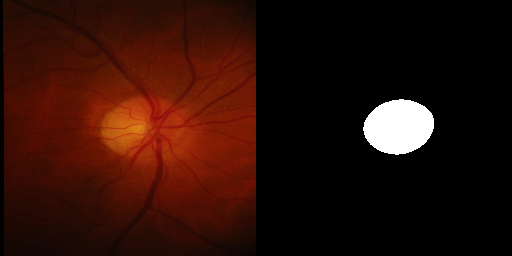

In [ ]:
ind = 111
cv2_imshow(cv2.hconcat([x[ind], cv2.merge([y[ind], y[ind], y[ind]])]))

In [ ]:
np.unique(y)

array([0., 1.], dtype=float32)

In [ ]:
y = to_categorical(y, 2)
y[10][112][112]

IndexError: ignored

In [ ]:
y.dtype

dtype('uint8')

In [ ]:
y.shape

(159, 256, 256)

In [ ]:
y = y.reshape((159, 256, 256, 1))
y.shape

AttributeError: ignored

In [ ]:
x = x/255
x.shape

(159, 256, 256, 3)

AttributeError: ignored

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(x,
    y, test_size=0.2, random_state=11)
 
x = y = nps = uni = Y = y_images = 0
trainX.shape, testX.shape, trainY.shape, testY.shape

((127, 256, 256, 3), (32, 256, 256, 3), (127, 256, 256), (32, 256, 256))

In [ ]:
trainX = trainX.transpose(0, 3, 1, 2)
trainY = trainY.transpose(0, 3, 1, 2)
testX = testX.transpose(0, 3, 1, 2)
testY = testY.transpose(0, 3, 1, 2)
trainX.shape, trainY.shape, testX.shape, testY.shape

((127, 3, 256, 256), (127, 2, 256, 256), (32, 3, 256, 256), (32, 2, 256, 256))

In [ ]:
x_img = y_img = y_images = mask_img1 = mask_img2 = im = img_name = mask_img = 0

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

yy = []
for i in range(7885747):
  yy.append([0])
for i in range(92237):
  yy.append([1])
yy = np.array(yy)
print(yy.shape)

(7977984, 1)


In [ ]:
from sklearn.utils import class_weight
print(yy.shape)
yy = yy.reshape(7977984)
print(yy.shape)
print(np.unique(yy))
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(yy), y=yy)
class_weights

(7977984, 1)
(7977984,)
[0 1]


array([ 0.50584834, 43.24720015])

In [ ]:
yy=0

#od
[ 0.5217884 , 11.97399276]
#oc
[ 0.50584834, 43.24720015]

[0.50584834, 43.24720015]

In [ ]:
trainX.shape

(127, 3, 256, 256)

In [ ]:
def lossFunc(true, pred):

      axis = -1 #if channels last 
      #axis=  1 #if channels first
      weightsList = [ 0.5217884 , 11.97399276]
      #argmax returns the index of the element with the greatest value
      #done in the class axis, it returns the class index    
      classSelectors = K.argmax(true, axis=axis) 
      #if your loss is sparse, use only true as classSelectors
      print('classSelectors1', classSelectors.shape)
      #considering weights are ordered by class, for each class
      #true(1) if the class index is equal to the weight index   
      classSelectors = [K.equal(K.cast(i,tf.int64), classSelectors) for i in range(len(weightsList))]
      print('classSelectors2', classSelectors)
      #for i in classSelectors:
      #  print(i)
      #print("!!!!!!!!!!!!!")
      #casting boolean to float for calculations  
      #each tensor in the list contains 1 where ground true class is equal to its index 
      #if you sum all these, you will get a tensor full of ones. 
      classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
      #print('classSelectors3', classSelectors)

      #for each of the selections above, multiply their respective weight
      weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 
      #print('weights', weights)

      #sums all the selections
      #result is a tensor with the respective weight for each element in predictions
      weightMultiplier = weights[0]
      for i in range(1, len(weights)):
          weightMultiplier = weightMultiplier + weights[i]
      #print('weightMultiplier', weightMultiplier, type(weightMultiplier))#, K.print_tensor(weightMultiplier, message="wm"))
      #make sure your originalLossFunc only collapses the class axis
      #you need the other axes intact to multiply the weights tensor
      loss = keras.losses.sparse_categorical_crossentropy(true,pred) 
      #print('loss', loss.shape, loss)
      loss = loss * weightMultiplier

      return loss


In [ ]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)

def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [ ]:
def unet_l(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(inputs)
    #conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool1)
    #conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool2)
    #conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool3)
    #conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool4)
    #conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(up6)
    #conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(up7)
    #conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(up8)
    #conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(up9)
    #conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='tanh', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# model.compile(optimizer=SGD(lr=3e-4, momentum=0.95),
#               loss=log_dice_loss,
#               metrics=[mean_IOU_gpu, dice_metric])
# model.summary()

model.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 256, 256  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 64, 256, 256  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer=Adam(0.0001),
              loss=lossFunc,
              metrics=[mean_IOU_gpu, 'accuracy', get_f1])
model.summary()

In [ ]:
%%time
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=9,verbose=2,factor=0.001,min_delta=0.01)
filepath = r"/content/drive/MyDrive/final-mid/od.h5"#-{epoch:02d}-{loss:.4f}-{accuracy:.4f}-{get_f1:.4f}-{val_loss:.4f}-{val_accuracy:.4f}-{val_get_f1:.4f}.h5"
check=ModelCheckpoint(filepath = filepath, verbose = 1, save_best_only = True)

H = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    callbacks = [check, ],
    batch_size=8,
    epochs=60,
    #sample_weight=cl,
    verbose=2,
  )

Epoch 1/60


InvalidArgumentError: ignored

In [ ]:
%%time
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=9,verbose=2,factor=0.001,min_delta=0.01)
filepath = r"/content/drive/MyDrive/eye_glaucoma/od_1.h5"#-{epoch:02d}-{loss:.4f}-{accuracy:.4f}-{get_f1:.4f}-{val_loss:.4f}-{val_accuracy:.4f}-{val_get_f1:.4f}.h5"
check=ModelCheckpoint(filepath = filepath, verbose = 1, save_best_only = True)

H = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    callbacks = [check, ],
    batch_size=8,
    epochs=30,
    #sample_weight=cl,
    verbose=2,
  )

In [ ]:
l = open('/content/drive/MyDrive/eye_glaucoma/OC_output_images/log.txt', 'w')
l.close()

In [ ]:
#Acuuracy plot
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(H.history['get_f1'])
plt.plot(H.history['val_get_f1'])
plt.title('model F1')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Loss plot
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(H.history['mean_IOU_gpu'])
plt.plot(H.history['val_mean_IOU_gpu'])
plt.title('model mean_IOU')
plt.ylabel('mean_IOU')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#testing

In [ ]:
model = load_model("/content/drive/MyDrive/eye_glaucoma/od_1.h5", custom_objects={'lossFunc': lossFunc, 'get_f1' : get_f1, 'mean_IOU_gpu':mean_IOU_gpu})


def classify_image(inp):
  img_final = inp.copy()
  inp = inp.reshape((1, 224, 224, 3))
  inp = inp/255
  pred = model.predict(inp)
  pp = pred[0]
  bg = pp[:,:,0]
  od = pp[:,:,1]
  bg = bg*255
  od = od*255
  bg[bg>=127] = 255
  bg[bg<127] = 0
  od[od>=127] = 255
  od[od<127] = 0
  flag = None
  output = None
  if(255 in list(np.unique(od))):
    flag = od
  
  flag = flag.astype(np.uint8)
  flag = cv2.cvtColor(flag,cv2.COLOR_GRAY2BGR)
  flag[np.where((flag==[255, 255, 255]).all(axis=2))] = [0,255,0]
  cv2.addWeighted(flag, 0.2, img_final.copy(), 1 - 0.2, 0, flag)
  final_output = cv2.hconcat([img_final, flag])
  return(final_output)

In [ ]:
for i in os.listdir('/content/drive/MyDrive/eye_glaucoma/OD_output_images'):
  if('_' not in i):
    os.remove('/content/drive/MyDrive/eye_glaucoma/OD_output_images/'+i)

In [ ]:
out = []
imgs = []
for i in tq(os.listdir('/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Healthy/Stereo Images')):
  img = cv2.imread('/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Healthy/Stereo Images/'+i)
  img1 = img[0:1424, 0:1072]
  img2 = img[0:1424, 1072:]
  img1 = cv2.resize(img1, (224, 224))
  img2 = cv2.resize(img2, (224, 224))

  o = classify_image(img1)
  cv2.imwrite('/content/drive/MyDrive/eye_glaucoma/OD_output_images/'+i.split('.')[0]+'_l.png', o)
  o = classify_image(img2)
  cv2.imwrite('/content/drive/MyDrive/eye_glaucoma/OD_output_images/'+i.split('.')[0]+'_r.png', o)

In [ ]:
#OC

In [ ]:
x = []
y = []
#path1 = '/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Glaucoma and suspects/'
#path2 = '/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Healthy/'
for path in [path1, path2]:
  for img_name in tq(natsorted(os.listdir(os.path.join(path, 'Stereo Images')))):
    x_img = cv2.imread(os.path.join(path, 'Stereo Images', img_name))
    mask_name = img_name.split('.')[0]+'-Cup-Avg.png'
    mask_img = cv2.imread(os.path.join(path, 'Average_masks', mask_name), 0)
    mask_img1 = mask_img[0:1424, 0:1072]
    mask_img2 = mask_img[0:1424, 1072:]
    
    if(255 in list(np.unique(mask_img1))):
      x_img = x_img[0:1424, 0:1072]
      x_img = cv2.resize(x_img, (224, 224))

      y_img = mask_img1.copy()
      y_img = cv2.resize(y_img, (224, 224))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255
      
    elif(255 in list(np.unique(mask_img2))):
      x_img = x_img[0:1424, 1072:]
      x_img = cv2.resize(x_img, (224, 224))

      y_img = mask_img2.copy()
      y_img = cv2.resize(y_img, (224, 224))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255

    else:
      print('Not good', img_name, mask_name)

    x.append(x_img)
    y.append(y_img)
    x.append(cv2.flip(x_img, 0))
    y.append(cv2.flip(y_img, 0))
    x.append(cv2.flip(x_img, 1))
    y.append(cv2.flip(y_img, 1))
    x.append(cv2.flip(x_img, -1))
    y.append(cv2.flip(y_img, -1))

x = np.array(x)
y = np.array(y)

In [ ]:
x.shape, y.shape

In [ ]:
ind = 250
cv2_imshow(cv2.hconcat([x[ind], cv2.merge([y[ind], y[ind], y[ind]])]))

In [ ]:
np.unique(y)

In [ ]:
y[y==255] = 1
np.unique(y, return_counts=True)

In [ ]:
y = to_categorical(y, 2)
y[10][112][112]

In [ ]:
y.shape

In [ ]:
x = x/255
x.shape

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(x,
    y, test_size=0.2, random_state=11)
 
x = y = nps = uni = Y = y_images = 0
trainX.shape, testX.shape, trainY.shape, testY.shape

In [ ]:
x_img = y_img = y_images = mask_img1 = mask_img2 = im = img_name = mask_img = 0

In [ ]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
yy = []
for i in range(15771494):
  yy.append([0])
for i in range(184474):
  yy.append([1])
yy = np.array(yy)
print(yy.shape)

In [ ]:
from sklearn.utils import class_weight
print(yy.shape)
yy = yy.reshape(15955968)
print(yy.shape)
print(np.unique(yy))
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(yy), y=yy)
class_weights

In [ ]:
yy=0
img1 = img2 = mask_img = o= o1 = 0

In [ ]:
#od
[ 0.5217884 , 11.97399276]
#oc
[ 0.50584834, 43.24720015]

In [ ]:
def lossFunc(true, pred):

      axis = -1 #if channels last 
      #axis=  1 #if channels first
      weightsList = [ 0.50584834, 43.24720015]
      #argmax returns the index of the element with the greatest value
      #done in the class axis, it returns the class index    
      classSelectors = K.argmax(true, axis=axis) 
      #if your loss is sparse, use only true as classSelectors
      #print('classSelectors1', classSelectors.shape)
      #considering weights are ordered by class, for each class
      #true(1) if the class index is equal to the weight index   
      classSelectors = [K.equal(K.cast(i,tf.int64), classSelectors) for i in range(len(weightsList))]
      #print('classSelectors2', classSelectors)
      #for i in classSelectors:
      #  print(i)
      #print("!!!!!!!!!!!!!")
      #casting boolean to float for calculations  
      #each tensor in the list contains 1 where ground true class is equal to its index 
      #if you sum all these, you will get a tensor full of ones. 
      classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
      #print('classSelectors3', classSelectors)

      #for each of the selections above, multiply their respective weight
      weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 
      #print('weights', weights)

      #sums all the selections
      #result is a tensor with the respective weight for each element in predictions
      weightMultiplier = weights[0]
      for i in range(1, len(weights)):
          weightMultiplier = weightMultiplier + weights[i]
      #print('weightMultiplier', weightMultiplier, type(weightMultiplier))#, K.print_tensor(weightMultiplier, message="wm"))
      #make sure your originalLossFunc only collapses the class axis
      #you need the other axes intact to multiply the weights tensor
      loss = keras.losses.categorical_crossentropy(true,pred) 
      #print('loss', loss.shape, loss)
      loss = loss * weightMultiplier

      return loss

In [ ]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)

def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [ ]:
input = Input((224, 224, 3))
c0 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(input)
c0 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(c0)
m0 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(c0)
d0 = Dropout(0.2)(m0)

c1 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(d0)
c1 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(c1)
m1 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(c1)
d1 = Dropout(0.3)(m1)

c2 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(d1)
c2 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(c2)
c2 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(c2)
m2 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(c2)
d2 = Dropout(0.3)(m2)

c3 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(d2)
c3 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(c3)
c3 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(c3)
m3 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(c3)
d3 = Dropout(0.4)(m3)

c4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(d3)
c4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(c4)
c4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(c4)
m4 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(c4)
d4 = Dropout(0.3)(m4)

dc0 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d4)
dc0 = concatenate([dc0, c4])
d5 = Dropout(0.4)(dc0)
dec0 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(d5)
dec0 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(dec0)
 
dc1 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(dec0)
dc1 = concatenate([dc1, c3])
d6 = Dropout(0.4)(dc1)
dec1 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(d6)
dec1 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(dec1)
 
dc2 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(dec1)
dc2 = concatenate([dc2, c2])
d7 = Dropout(0.4)(dc2)
dec2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(d7)
dec2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(dec2)
 
dc3 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(dec2)
dc3 = concatenate([dc3, c1])
d8 = Dropout(0.4)(dc3)
dec3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(d8)
dec3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(dec3)
 
dc4 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(dec3)
dc4 = concatenate([dc4, c0])
d9 = Dropout(0.4)(dc4)
dec4 = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(d9)
dec4 = Conv2D(filters=2, kernel_size=(3,3), padding="same", activation="softmax")(dec4)

model = Model(inputs=[input], outputs=[dec4])
model.summary()

In [ ]:
model = load_model("/content/drive/MyDrive/eye_glaucoma/oc.h5", custom_objects={'lossFunc': lossFunc, 'get_f1' : get_f1, 'mean_IOU_gpu':mean_IOU_gpu})

In [ ]:
model.compile(optimizer=Adam(0.0001),
              loss=lossFunc,
              metrics=[mean_IOU_gpu, 'accuracy', get_f1])

In [ ]:
%%time
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=9,verbose=2,factor=0.001,min_delta=0.01)
filepath = r"/content/drive/MyDrive/eye_glaucoma/oc_11.h5"#-{epoch:02d}-{loss:.4f}-{accuracy:.4f}-{get_f1:.4f}-{val_loss:.4f}-{val_accuracy:.4f}-{val_get_f1:.4f}.h5"
check=ModelCheckpoint(filepath = filepath, verbose = 1, save_best_only = True)

H = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    callbacks = [check, ],
    batch_size=8,
    epochs=30,
    #sample_weight=cl,
    verbose=2,
  )

'''
Epoch 26: val_loss improved from 0.03707 to 0.03548, saving model to /content/drive/MyDrive/eye_glaucoma/oc_2.h5
32/32 - 32s - loss: 0.0421 - mean_IOU_gpu: 0.9571 - accuracy: 0.9780 - get_f1: 0.9780 - val_loss: 0.0355 - val_mean_IOU_gpu: 0.9605 - val_accuracy: 0.9798 - val_get_f1: 0.9798 - 32s/epoch - 1s/step
'''

In [ ]:
#accuracy for OD
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(H.history['get_f1'])
plt.plot(H.history['val_get_f1'])
plt.title('model F1')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Loss plot for OD
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(H.history['mean_IOU_gpu'])
plt.plot(H.history['val_mean_IOU_gpu'])
plt.title('model mean_IOU')
plt.ylabel('mean_IOU')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#testing of OD

In [ ]:
oc_segmentation_model = load_model("/content/drive/MyDrive/eye_glaucoma/oc.h5", custom_objects={'lossFunc': lossFunc, 'get_f1' : get_f1, 'mean_IOU_gpu':mean_IOU_gpu})


def oc_segmentation(inp, mask):
  img_final = inp.copy()
  inp = inp.reshape((1, 224, 224, 3))
  inp = inp/255
  pred = model.predict(inp)
  pp = pred[0]
  bg = pp[:,:,0]
  od = pp[:,:,1]
  bg = bg*255
  od = od*255
  bg[bg>=127] = 255
  bg[bg<127] = 0
  od[od>=127] = 255
  od[od<127] = 0
  flag = None
  output = None
  if(255 in list(np.unique(od))):
    flag = od.copy()
  
  flag = flag.astype(np.uint8)
  flag = cv2.cvtColor(flag,cv2.COLOR_GRAY2BGR)
  mask1 = flag.copy()
  flag[np.where((flag==[255, 255, 255]).all(axis=2))] = [0,255,0]
  cv2.addWeighted(flag, 0.2, img_final.copy(), 1 - 0.2, 0, flag)
  final_output = cv2.hconcat([img_final, flag])
  final_output1 = cv2.hconcat([mask, mask1])
  return(final_output, final_output1)

In [ ]:
for i in os.listdir('/content/drive/MyDrive/eye_glaucoma/OC_output_images'):
  os.remove('/content/drive/MyDrive/eye_glaucoma/OC_output_images/'+i)
for i in os.listdir('/content/drive/MyDrive/eye_glaucoma/OC_output_masks'):
  os.remove('/content/drive/MyDrive/eye_glaucoma/OC_output_masks/'+i)  

In [ ]:
out = []
imgs = []
for i in tq(os.listdir('/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Glaucoma and suspects/Stereo Images')):
  img = cv2.imread('/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Glaucoma and suspects/Stereo Images/'+i)
  img1 = img[0:1424, 0:1072]
  img2 = img[0:1424, 1072:]
  img1 = cv2.resize(img1, (224, 224))
  img2 = cv2.resize(img2, (224, 224))

  mask_name = i.split('.')[0]+'-Cup-Avg.png'
  mask_img = cv2.imread('/content/drive/MyDrive/eye_glaucoma/RIM-ONE r3/Glaucoma and suspects/Average_masks/'+mask_name)
  mask_img1 = mask_img[0:1424, 0:1072]
  mask_img2 = mask_img[0:1424, 1072:]
  mask_img1 = cv2.resize(mask_img1, (224, 224))
  mask_img2 = cv2.resize(mask_img2, (224, 224))
  try:
    o, o1 = classify_image(img1, mask_img1)
    cv2.imwrite('/content/drive/MyDrive/eye_glaucoma/OC_output_images/'+i.split('.')[0]+'_l.png', o)
    cv2.imwrite('/content/drive/MyDrive/eye_glaucoma/OC_output_masks/'+i.split('.')[0]+'_l.png', o1)
    o, o1 = classify_image(img2, mask_img2)
    cv2.imwrite('/content/drive/MyDrive/eye_glaucoma/OC_output_images/'+i.split('.')[0]+'_r.png', o)
    cv2.imwrite('/content/drive/MyDrive/eye_glaucoma/OC_output_masks/'+i.split('.')[0]+'_l.png', o1)
  except:
    print(np.unique(o), np.unique(o1))

In [ ]:
cv2_imshow(mask_img1)

In [ ]:
oc_segmentation_model = load_model("/content/drive/MyDrive/eye_glaucoma/Sharing/oc_1.h5", custom_objects={'lossFunc': oc_lossFunc, 'get_f1' : get_f1, 'mean_IOU_gpu':mean_IOU_gpu})


def oc_segmentation(inp):
  img_final = inp.copy()
  inp = inp.reshape((1, 224, 224, 3))
  inp = inp/255
  pred = oc_segmentation_model.predict(inp)
  pp = pred[0]
  bg = pp[:,:,0]
  od = pp[:,:,1]
  bg = bg*255
  od = od*255
  bg[bg>=127] = 255
  bg[bg<127] = 0
  od[od>=127] = 255
  od[od<127] = 0
  flag = None
  output = None
  if(255 in list(np.unique(od))):
    flag = od.copy()
  
  flag = flag.astype(np.uint8)
  return(flag)

In [ ]:
x = []
y = []
shape = []
out = []
path1 = '/content/drive/MyDrive/eye_glaucoma/Sharing/RIM-ONE r3/Healthy/Stereo Images'
path2 = '/content/drive/MyDrive/eye_glaucoma/Sharing/RIM-ONE r3/Glaucoma and suspects/Stereo Images'

for path in [path2]:
  label = path.split('/')[-2]
  for i in tq(os.listdir(path)):
    img = cv2.imread(os.path.join(path, i))
    img1 = img[0:1424, 0:1072]
    img2 = img[0:1424, 1072:]
    img1 = cv2.resize(img1, (224, 224))
    img2 = cv2.resize(img2, (224, 224))

    o1 = od_segmentation(img1)
    o2 = od_segmentation(img2)

    c1, _ = cv2.findContours(o1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c2, _ = cv2.findContours(o2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    oc1 = oc_segmentation(img1)
    oc2 = oc_segmentation(img2)

    cc1, _ = cv2.findContours(oc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cc2, _ = cv2.findContours(oc2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    try:
        xp1, yp1, w1, h1 = cv2.boundingRect(c1[0])
        xp2, yp2, w2, h2 = cv2.boundingRect(cc1[0])
        r1 = w2/w1

        xp1, yp1, w1, h1 = cv2.boundingRect(c2[0])
        xp2, yp2, w2, h2 = cv2.boundingRect(cc2[0])
        r2 = w2/w1
      
        print('ratio', r1, r2)
    
    except:
      print(i)

In [ ]:
x = []
y = []
shape = []
out = []
path1 = '/content/drive/MyDrive/eye_glaucoma/Sharing/RIM-ONE r3/Healthy/Stereo Images'
path2 = '/content/drive/MyDrive/eye_glaucoma/Sharing/RIM-ONE r3/Glaucoma and suspects/Stereo Images'

for path in [path1]:
  label = path.split('/')[-2]
  for i in tq(os.listdir(path)):
    img = cv2.imread(os.path.join(path, i))
    img1 = img[0:1424, 0:1072]
    img2 = img[0:1424, 1072:]
    img1 = cv2.resize(img1, (224, 224))
    img2 = cv2.resize(img2, (224, 224))

    o1 = od_segmentation(img1)
    o2 = od_segmentation(img2)

    c1, _ = cv2.findContours(o1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c2, _ = cv2.findContours(o2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    oc1 = oc_segmentation(img1)
    oc2 = oc_segmentation(img2)

    cc1, _ = cv2.findContours(oc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cc2, _ = cv2.findContours(oc2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    try:
        xp1, yp1, w1, h1 = cv2.boundingRect(c1[0])
        xp2, yp2, w2, h2 = cv2.boundingRect(cc1[0])
        r1 = w2/w1

        xp1, yp1, w1, h1 = cv2.boundingRect(c2[0])
        xp2, yp2, w2, h2 = cv2.boundingRect(cc2[0])
        r2 = w2/w1
      
        print('ratio', r1, r2)
    
    except:
      print(i)